# Chapter 8 -  Detecting Overlapping communities

This is the first section in part II of the textbook (Additional Material) 

The problem of graph clustering is well studied, in particular the case where the vertices are partitioned into
non-overlapping communities.
We already saw one algorithm, ECG, which is among the best performing algorithms for graph partitioning, and also
provides edge weights (strength of association) based on number of votes. 
Here, we look at the problem of graph clustering where:
* vertices can be part of several communities (overlapping communities)
* vertices can be part of no community ("noise" vertices)

We explore the following three methods:
* methods based on finding overlapping cliques (a clique is a complete subgraph)
* methods based on splitting vertices into multiple personae, and
* methods based on clustering the edges.

We illustrate those methods here using the small Karate Club graph, a word association graph and artificial
ABCD benchmark graphs. We also propose some improvements inspired by COmmunity Association Strength scores (CAS) and the ECG clustering algorithm.


## Requirements

* For the last experiment in this notebook, the following C++ packages need to be installed:
 * LFR benchmark with overlapping communities; download, untar and compile 'binary_networks.tar' from: https://sites.google.com/site/andrealancichinetti/files We had issues with the program sometimes not terminating correctly on Windows; in such case, just delete the last part of the print_network() function in file benchm.cpp (printing to statistics.dat) and re-compile.
 * overlapping NMI measure (oNMI): download and compile from: https://github.com/aaronmcdaid/Overlapping-NMI 
* also pip install omega-index-py3 (ref: https://pypi.org/project/omega-index-py3/)

Finally, adjust the locations of directories in next cell. For Windows, you may need to use "\\" or "\\\\" as delimiters, for example 'C:\\oNMI\\onmi.exe'


In [3]:
datadir='../Datasets/'
LFRo = '../LFR_Overlap/benchmark' ## overlapping LFR executable
oNMI = '../oNMI/onmi'             ## overlapping NMI executable


In [4]:
import igraph as ig
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from itertools import combinations
from IPython.display import display, SVG
import time
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import subprocess
import partition_igraph
import os
#import omega_index_py3 as omega
import pickle
import random
import omega_index

#%config Completer.use_jedi = False


# Book part 1

1. Describe the three algorithms and show Zac (in one row) for the 3 cases, comparing the omega with GT.

2. Describe pre- and post-processing, show pre- can improve CPM (only give omega) and post- can improve edge (also, omega)

# 1. CPM (clique percolation method)

The first algorithm we consider is the Clique Percolation Method, which can
be summarized as:
* fix the clique size $k$ (typically k=3 or 4)
* for each $k$-clique, join all other $k$-cliques with $k-1$ vertices in common, in turn (the percolation)
* continue until all $k$-cliques are exhausted

Is is based on:

Derényi I., *et al.*, Clique percolation in random networks, Phys. Rev. Lett., 2005, vol. 94 (pg. 160-202)


In [5]:
def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


#### CPM on the Zachary Graph

We illustrate the different CPM-based algorithms with the well-known Karate Club dataset, which model interaction between 34 members. The 2 communities correspond to groups forming after a split in two "factions". Modularity-based algorithms usually find 4 or 5 communities.
Below, we color the nodes according to the 2 factions after the split.  

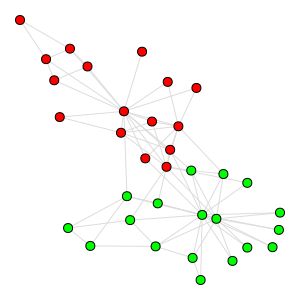

In [6]:
## Zachary graph and its two communities
zac = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist',directed=False)
c = np.loadtxt(datadir+'Zachary/zachary.communities',dtype='uint16')
zac.vs['comm'] = [c[int(x['name'])] for x in zac.vs]

## layout stored from Chapter 5 notebook
## this was generated using the Fruchterman-Reingold method
with open(datadir+"Zachary/layout.pkl","rb") as fn:
    ly_zac = pickle.load(fn)
zac['layout'] = [ly_zac[int(x['name'])] for x in zac.vs] 

## plotting parameters
zac.vs['size'] = 9
zac.es['color'] = 'gainsboro'
#pal = ig.drawing.colors.GradientPalette("white","black",n=max(zac.vs['comm'])+1)
pal = ig.drawing.colors.ClusterColoringPalette(n=max(zac.vs['comm'])+1)
zac.vs['color'] = [pal[i] for i in zac.vs['comm']]

## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


In [7]:
## assign colors and shapes w.r.t. overlapping clusters
## white: no cluster
## black square: overlap
## the rest are shown as colored circles
def color_nodes(g, communities, greyscale=False):
    g.vs['_oc'] = [ [] for i in range(g.vcount())]
    for i in range(len(communities)):
        for j in communities[i]:
            g.vs.find(j)['_oc'].append(i)
    if greyscale:
        pal = ig.drawing.colors.GradientPalette('white','black',n=len(communities)+2)
    else:
        pal = ig.drawing.colors.ClusterColoringPalette(n=len(communities))
    g.vs['shape'] = 'circle'
    for v in g.vs:
        if len(v['_oc'])==0:
            v['color'] = 'white'
        else: 
            if len(v['_oc'])>1:
                v['color'] = 'black'
                v['shape'] = 'square'
            else:
                if greyscale:
                    v['color'] = pal[v['_oc'][0]+1]
                else:
                    v['color'] = pal[v['_oc'][0]]


####  Running the CPM algorithm

* We run the CPM algorithm as is on the Karate graph.
* Nodes that belong to 2 or more clusters are represented as squares.
* You can select col='grey' for greyscale, but this is hard to distinguish with several clusters
* We obtain one large community, two small ones and two orphan nodes (shown in white)

In [8]:
zac_gt = {}
for i in set(zac.vs['comm']):
    zac_gt[i] = [v['name'] for v in zac.vs if v['comm']==i]


0.09414714766056873


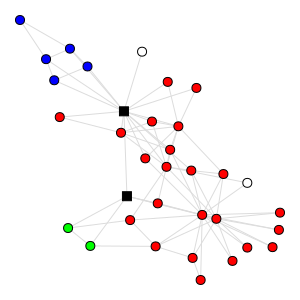

In [9]:
## CPM with k=3
X = CPM(zac, k=3)
color_nodes(zac, X, greyscale=False)
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)

## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


0.09549071618037135


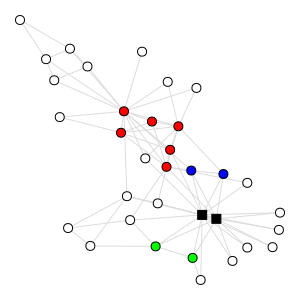

In [10]:
## CPM with k=4
X = CPM(zac, k=4)
color_nodes(zac, X, greyscale=False)
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)

## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


0.5230697890099699


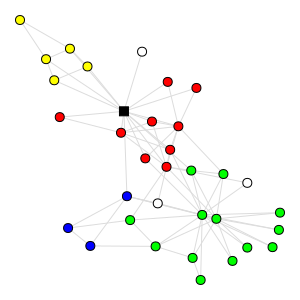

In [11]:
## filter edges with small ECG weight (threshold or under)
threshold = 0
np.random.seed(123)
random.seed(123)
zac.es['ecg_w'] = zac.community_ecg(ens_size=32, min_weight=0).W
zac_sg = zac.subgraph_edges([e for e in zac.es if e['ecg_w']>threshold])
X = CPM(zac_sg, k=3)
color_nodes(zac, X, greyscale=False)
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)

## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


# 2. Ego-Splitting method

The Ego-Splitting framework is based on paper by A. Epasto, S. Lattanzi and R.P. Leme at KDD 2017:

https://www.kdd.org/kdd2017/papers/view/ego-splitting-framework-from-non-overlapping-to-overlapping-clusters


In summary, the steps are:
* For each vertex $v$:
 * build the ego-net for $v$ (minus self)
 * cluster this ego-net using a local method, such as label propagation (LP) or connected components (CC)
 * "split" vertex $v$ into one persona per ego-net cluster
* Cluster this new graph (with duplicated vertices) with some graph partitioning algorithm such as LP or ECG. 
 * We can set a minimum community size to avoid tiny ones.

The original paper uses a LP method based on the Potts model, but we will use the Label Propagation from Raghavan *et. al.* which is implemented in igraph.


In [12]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


0.6216106839336302


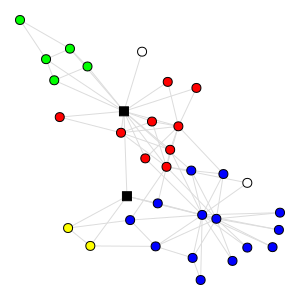

In [13]:
## ego-split
X = EgoSplit(zac, algo='ECG') ## pick final algorithm as parameter (LP or ECG)
X = [set(l) for l in X if len(l)>=3] ## min community size set to 3
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)
color_nodes(zac, X, greyscale=False)
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


# 3. Edge Clustering 

We can obtain overlapping communities by clustering edges instead of vertices.
The algorithm can be described as follows:
* for each pair of edges sharing a node, say $(i,k)$ and $(j,k)$, compute some similarity measure between the neighborhoods of vertices $i$ and $j$, such as the Jaccard measure
* perform hierarchical clustering on the edges with this similarity matrix

It is based on:

Ahn, YY., Bagrow, J., Lehmann, S. Link communities reveal multiscale complexity in networks. Nature 466, 761–764 (2010). https://doi.org/10.1038/nature09182

This can be implemented by considering the connected components for the line-graph of the original graph using varying thresholds for the Jaccard measure.
* line graph Lg(G) represents ties between edges of G
* Lg(G) nodes are edges in G
* edges sharing a node in G are linked by an edge in Lg(G)

We pick the "best" clustering in the hierarchy based on the modularity scores on the line graph.


In [14]:
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for e in lg.es:
        A = set(g.es[e.tuple[0]].tuple)
        B = set(g.es[e.tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighbors(x[0]),g.neighbors(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.connected_components().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

0.4195823927765237


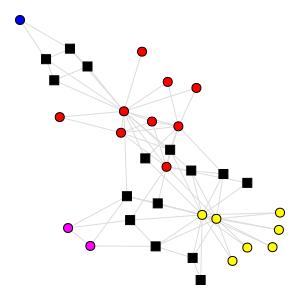

In [15]:
## cluster
X = edgeCluster(zac) ## pick final algorithm as parameter (LP or ECG)
X = [set(l) for l in X if len(l)>=3] ## min community size set to 3
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)
color_nodes(zac, X, greyscale=False)
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


# 4. Post processing

Example with CAS?

Take the following angle: 3 algorithms, plus pre-processing (eg. edge weights) and/or post-

Here, drop nodes NOT strongly CAS'ed to 1+ of their community

In [16]:
## community association strength
def cas(G, A):
    deg = np.array(G.degree())
    deg_int = np.array([sum([A[i] == A[j] for i in G.neighbors(j)]) for j in range(G.vcount())])
    Vol = sum(deg)
    Vol_A = np.zeros(max(A)+1, dtype='int')
    for i in range(G.vcount()):
        Vol_A[A[i]] += deg[i]
    return deg_int/deg - (np.array([Vol_A[A[i]] for i in range(G.vcount())]) - deg)/Vol


In [17]:
X = edgeCluster(zac) ## pick final algorithm as parameter (LP or ECG)
X = [set(l) for l in X if len(l)>=3] ## min community size set to 3
Y = []
for i in range(len(X)):
    zac.vs['_com'] = np.arange(1,zac.vcount())
    for x in X[i]:
        zac.vs.find(x)['_com'] = 0
    c = cas(zac, zac.vs['_com']) 
    Y.append(set([zac.vs[i]['name'] for i in range(len(c)) if c[i]>.1]))

0.4195823927765237


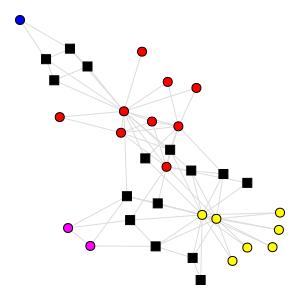

In [18]:
print(omega_index.Omega({i:list(X[i]) for i in range(len(X))}, zac_gt).omega_score)
color_nodes(zac, X, greyscale=False)
## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


0.6707185458676512


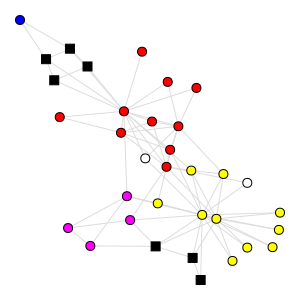

In [19]:
print(omega_index.Omega({i:list(Y[i]) for i in range(len(Y))}, zac_gt).omega_score)
color_nodes(zac, Y, greyscale=False)
## plot
ig.plot(zac,layout=zac['layout'], bbox=(0,0,300,300))


# Word Association Graph Example

We consider a graph built from the Word Association dataset (U of South Florida) based on:

* G. Palla *et al.*, "Uncovering the overlapping structure of complex networks in nature and society", Nature 435, 814-818 (2005).

In a nutshell, we build a graph with edges between pairs of similar words. We used a threshold of $w^*=.025$ for the association strength and use $k=4$ for the clique size. We use this dataset to illustrate the usefulness of overlapping clusters to discover various contexts of words. 

We look at two versions of CPM:
* using the ECG-based version, and
* using the association strength as edge weight.


In [20]:
## build the graph
wg = ig.Graph.Read_Ncol(datadir+'Words/words.txt', names=True, directed=False, weights=True)
wg = wg.simplify(combine_edges="sum") ## sum association strength scores
wg = wg.subgraph_edges([e for e in wg.es if e['weight'] >= .025]) ## prune low weight edges
wg.vs['label'] = wg.vs['name']
print(wg.vcount(),'nodes and',wg.ecount(),'edges')


5017 nodes and 29266 edges


In [21]:
for word in ['MATH', 'DOG', 'MONEY']: ## you can try other words; all words are CAPITALIZED

    ## get 2-hop ego-net
    v = wg.vs.find(name=word)
    n = wg.neighborhood(v,order=2)
    sg = wg.subgraph(n)

    ## filter edges w.r.t. ECG score
    threshold = 0
    np.random.seed(123)
    random.seed(123)
    sg.es['ecg_w'] = sg.community_ecg(ens_size=32, min_weight=0).W
    sg = sg.subgraph_edges([e for e in sg.es if e['ecg_w']>threshold])

    ## cluster and show results containing the given word
    X = CPM(sg, k=4)
    print('\nShowing clusters for the word',word)
    for x in X:
        if word in x:
            print(sorted(x))



Showing clusters for the word MATH
['ADD', 'CALCULATE', 'CALCULATOR', 'COMPUTE', 'COMPUTER', 'FIGURE', 'MATH']
['ADD', 'DIVIDE', 'DIVISION', 'MATH', 'MULTIPLY', 'QUOTIENT', 'SUBTRACT']
['ALGEBRA', 'ARITHMETIC', 'CALCULUS', 'FACTOR', 'MATH', 'NUMBER', 'TRIGONOMETRY']
['ALGEBRA', 'EQUATION', 'FORMULA', 'MATH']

Showing clusters for the word DOG
['ANIMAL', 'BEAR', 'CAT', 'CLAW', 'DOG', 'FURRY', 'MAMMAL', 'PAW', 'PET', 'RAT', 'STRAY', 'TAIL', 'VET']
['ANIMAL', 'COYOTE', 'DOG', 'WILD', 'WOLF']
['ANIMALS', 'CAT', 'DOG', 'PETS']

Showing clusters for the word MONEY
['BILL', 'CHECK', 'DEBT', 'DUE', 'FEE', 'MONEY', 'PAYMENT', 'RECEIPT']
['CENT', 'CENTS', 'CHANGE', 'COIN', 'DIME', 'DOLLAR', 'MONEY', 'NICKEL', 'PENNY', 'QUARTER']
['BUY', 'CASH', 'CHECK', 'CLOTHES', 'CONSUMER', 'CUSTOMER', 'MALL', 'MARKET', 'MONEY', 'OWE', 'PAY', 'PLAZA', 'PURCHASE', 'RECEIPT', 'RENT', 'SALE', 'SELL', 'SHOP', 'SHOPPING', 'SPEND', 'STORE']
['FAME', 'FORTUNE', 'LIMOUSINE', 'LUXURY', 'MANSION', 'MONEY', 'POOR', 'POV

In [22]:
for word in ['MATH','DOG','MONEY']: ## you can try other words; all words are CAPITALIZED

    ## get 2-hop ego-net
    v = wg.vs.find(name=word)
    n = wg.neighborhood(v,order=2)
    sg = wg.subgraph(n)

    ## filter edges w.r.t. association strength scores
    threshold = 0.025
    sg = sg.subgraph_edges([e for e in sg.es if e['weight']>threshold])

    ## cluster and show results containing the given word
    X = CPM(sg, k=4)
    print('\nShowing clusters for the word',word)
    for x in X:
        if word in x:
            print(sorted(x))



Showing clusters for the word MATH
['ALGEBRA', 'ARITHMETIC', 'CALCULUS', 'FACTOR', 'GEOMETRY', 'HARD', 'MATH', 'NUMBER', 'TRIGONOMETRY']
['ADD', 'DIVIDE', 'DIVISION', 'MATH', 'MULTIPLY', 'QUOTIENT', 'SUBTRACT']
['ANGLE', 'GEOMETRY', 'MATH', 'TANGENT']
['ADD', 'CALCULATE', 'CALCULATOR', 'COMPUTE', 'COMPUTER', 'FIGURE', 'MATH']
['ALGEBRA', 'EQUATION', 'FORMULA', 'MATH']

Showing clusters for the word DOG
['ANIMAL', 'BEAR', 'BIRD', 'CAT', 'CLAW', 'DOG', 'FURRY', 'MAMMAL', 'PAW', 'PET', 'RAT', 'STRAY', 'TAIL', 'VET']
['ANIMALS', 'CAT', 'DOG', 'PETS']
['ANIMAL', 'COYOTE', 'DOG', 'FOX', 'HUNT', 'WILD', 'WOLF']

Showing clusters for the word MONEY
['BUY', 'CASH', 'CHECK', 'CLOTHES', 'CONSUMER', 'CUSTOMER', 'MALL', 'MARKET', 'MONEY', 'OWE', 'PAY', 'PLAZA', 'PURCHASE', 'RECEIPT', 'RENT', 'SALE', 'SELL', 'SHOP', 'SHOPPING', 'SPEND', 'STORE']
['FAME', 'FORTUNE', 'GOLD', 'LIMOUSINE', 'LUXURY', 'MANSION', 'MONEY', 'POOR', 'POVERTY', 'POWER', 'PRESTIGE', 'PROSPER', 'RICH', 'SUCCEED', 'SUCCESS', 'WE

# Study over benchmark graphs -- ICI!!

We compare several methods we presented over "LFR with overlaps" benchmark graphs, with varying noise parameter $\mu$. In order to compare the (possibly) overlapping clusters with the ground truth, we use "oNMI", a modification of NMI that can handle overlapping communities, and the Omega index, a variation of the Rand index.

Running the code below may take a several minutes as we do several repeats for a range of $\mu$ values


## ABCD-oo graphs

In [177]:
## Read ABCD+oo graph
path = datadir+'ABCDoo/'
def readGraph(xi=0.10, eta=1.0):
    fn = path+'networkfile_'+str(xi)+'_'+str(eta)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile_'+str(xi)+'_'+str(eta)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(str(i))
    return L


In [229]:
L = []
threshold = 0.1
for xi in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]:
#for xi in [0.1,0.35,0.6]:
    for eta in [1.0,1.25,1.5,1.75,2.0]:
    #for eta in [1.0,1.5,2.0]:
        print(xi,eta)
        g = readGraph(xi=xi,eta=eta)
        g.vs['name'] = [str(i) for i in g.vs.indices]
        gt = {i:j for i,j in enumerate(mems2comms(g.vs['comms'])[1:])}
        g.es['ecg_w'] = g.community_ecg(ens_size=32, min_weight=0).W
        g_sg = g.subgraph_edges([e for e in g.es if e['ecg_w']>threshold])
        oi = 0
        for rep in range(3):
            X = EgoSplit(g)
            X = [set(l) for l in X if len(l)>=3] ## min community size set to 3
            oi += omega_index.Omega({i:list(X[i]) for i in range(len(X))},gt).omega_score
        L.append([0,xi,eta,oi/3])
        oi = 0
        for rep in range(3):
            X = EgoSplit(g_sg)
            X = [set(l) for l in X if len(l)>=3] ## min community size set to 3
            oi += omega_index.Omega({i:list(X[i]) for i in range(len(X))},gt).omega_score
        L.append([1,xi,eta,oi/3])
_df = pd.DataFrame(L, columns=['pre','xi','eta','omega'])


0.1 1.0
0.1 1.25
0.6 1.75
0.6 2.0
0.65 1.0
0.65 1.25
0.65 1.5
0.65 1.75
0.65 2.0


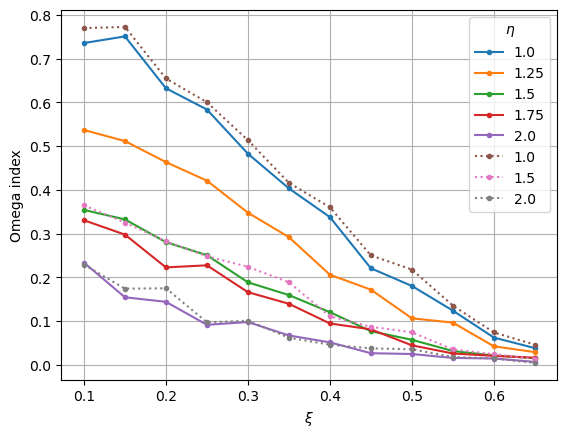

In [230]:
for eta in [1.0,1.25,1.5,1.75,2.0]:
    __df = _df[ (_df.eta==eta) & (_df.pre==0) ]
    plt.plot(__df.xi,__df.omega,'.-',label=eta)
for eta in [1.0,1.5,2.0]:
    __df = _df[ (_df.eta==eta) & (_df.pre==1) ]
    plt.plot(__df.xi,__df.omega,'.:',label=eta)
plt.legend(title=r"$\eta$")
plt.grid()
plt.ylabel('Omega index')
plt.xlabel(r'$\xi$');


In [ ]:
## Reformat -- from LFR_overlap communities to 1 community per line
def mapLFRcommunity(infile=None,outfile=None):
    fn = infile
    with open(fn) as f:
        content = f.readlines()
    f.close()
    content = [x.strip() for x in content] 
    L = []
    for line in content:
        x = line.split('\t')[1]
        y = x.split(' ')
        L.append([int(i) for i in y])
    m = np.max([item for sublist in L for item in sublist])
    C = [[] for i in range(m)]
    for i in range(len(L)):
        for j in L[i]:
            C[j-1].append(i+1)
    import  csv
    fn = outfile
    with open(fn,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(C)
    f.close()
    return C

## get communities and compute oNMI
def oNMIrun(L, min_size=3, comm='./_communities', fn='./_temp'):
    C = [l for l in L if len(l) >= min_size]
    with open(fn,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(C)
    f.close()   
    x = float(subprocess.check_output([oNMI,comm,fn]).decode("utf-8").split()[1])
    return x

## compute Omega index vs GT
def omegaIndex(L, min_size=3, gt='./_communities'):
    s1 = {}
    C = [l for l in L if len(l) >= min_size]
    for i in range(len(C)):
        s1[str(i)] = list(C[i])
    ## ground truth
    lines = [line.rstrip('\n') for line in open(gt)]
    s2 = {}
    for i in range(len(lines)):
        x = [j for j in lines[i].split(' ')]
        s2[str(i)] = x
    return omega.Omega(s1,s2).omega_score

MUs = np.arange(5,71,5) ## range of mu's for the experiments below

### running the experiment

Uncomment the code below to re-run, or read the results from thr supplied pickle file.


In [ ]:
## load experiment results in D
with open(datadir+"Overlap/lfr_100.pkl","rb") as f:
    D = pickle.load(f)


In [ ]:
## oNMI - plot for the book
M = D.groupby(by=['mu','algo']).mean()
algo = ["'CPM'","'H-CPM'","'ego-split-cc-lp'"]
ltyp = ['--','-',':','-.']
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['oNMI'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black')
plt.legend(["CPM","H-CPM","ego-split"])
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('oNMI',fontsize=14)
plt.grid();
#plt.savefig('overlap_onmi.eps');

In [ ]:
## Omega - plot for the book
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['Omega'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black')
plt.legend(["CPM","H-CPM","ego-split"])
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('Omega',fontsize=14)
plt.grid();
#plt.savefig('overlap_omega.eps');

In [ ]:
## ratio of communities found to true number - plot for the book
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['delta(n_comm)'])]
    plt.semilogy([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black',base=2)
plt.legend(["CPM","H-CPM","ego-split"])
#plt.hlines(0,0.05,.7,linestyles=':',color='black')
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('ratio of |communities|',fontsize=14)
plt.ylim((1/4,2))
plt.grid();
#plt.savefig('overlap_n-comm.eps');

In [ ]:
## oNMI - color plot
M = D.groupby(by=['mu','algo']).mean()
algo = ["'CPM'","'H-CPM'","'ego-split-cc-ecg'","'ego-split-cc-lp'","'ego-split-lp-lp'","'edges'"]
ltyp = ['--','-',':',':',':','-.']
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['oNMI'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('oNMI',fontsize=14);


In [ ]:
## Omega - color plot, more algorithms
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['Omega'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('Omega',fontsize=14);


In [ ]:
## ratio of communities found to true number - color plot
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['delta(n_comm)'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.hlines(0,0.05,.7,color='grey')
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('delta(n_comm)',fontsize=14);


### same experiment with more overlap

In [ ]:
## load experiment results in D
with open(datadir+"Overlap/lfr_250.pkl","rb") as f:
    D = pickle.load(f)


In [ ]:
## oNMI
M = D.groupby(by=['mu','algo']).mean()
algo = ["'CPM'","'H-CPM'","'ego-split-cc-ecg'","'ego-split-cc-lp'","'ego-split-lp-lp'","'edges'"]
ltyp = ['--','-',':',':',':','-.']
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['oNMI'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('oNMI',fontsize=14);


In [ ]:
## Omega
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['Omega'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('Omega',fontsize=14);


In [ ]:
## ratio of communities found to true number
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['delta(n_comm)'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.hlines(0,0.05,.7,color='grey')
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('delta(n_comm)',fontsize=14);


### Remarks

* ego-net based method gives better results than CPM or edge clustering, in particular when using CC in the first step; using ECG in the second step improves ego-net method slightly over LP;
* using ECG and keeping penultimate level in Hierarchical-CPM helps a lot;
* CPM in general tends to find less communities;
* edge clustgering yields too many communities w.r.t. ground-truth;


## Measures

We compare oNMI and Omega measures for random partitions to see if there are any clear bias, for example toward partitions with lots (or very little) parts.


In [ ]:
## generate LFR-overlap graph
cmd = LFRo+' -N 1000 -k 10 -maxk 50 -minc 10 -maxc 100 -on 100 -om 2 -mu .25'
#cmd = LFRo+' -N 1000 -k 10 -maxk 50 -minc 10 -maxc 100 -mu .25'
x = os.system(cmd+' >/dev/null 2>&1')
## map resulting communities to proper format for oNMI
x = mapLFRcommunity('./community.dat','./_communities')
nc = len(x)
## build the graph
g = ig.Graph.Read_Ncol('./network.dat',directed=False)
g = g.simplify() ## edges are repeated twice with LFRo
print('number of communities:',len(x))

In [ ]:
## random partition with r parts: 1000 nodes, 100 in 2 communities
mc = 5  ## min comm size
X = []
for r in np.arange(2,61,2):
    #n = [str(i) for i in np.arange(1,1001)]+[str(i) for i in np.arange(1,101)]
    n = [str(i) for i in np.arange(1,1001)]
    rc = np.random.choice(r,len(n))
    L = [set() for i in range(r)]
    for i in range(len(n)):
        L[rc[i]].add(n[i])
    X.append([r,oNMIrun(L,min_size=mc),omegaIndex(L,min_size=mc)])
D = pd.DataFrame(X,columns=['comms','oNMI','Omega'])

In [ ]:
## results for oNMI and Omega index;
## oNMI is almost flat 0; Omega is very close to 0 without any clear patters w.r.t. number of parts.
x = np.arange(2,61,2)
plt.plot(x,D['oNMI'],label='oNMI',linestyle='-',color='black')
plt.plot(x,D['Omega'],label='Omega',linestyle='--',color='black')
plt.legend()
plt.grid()
plt.xlabel('Number of communities',fontsize=14);
#plt.savefig('measures_bias.eps');
